## Problem Statement

The goal of this project is to see what classifiers work best in predicting heart disease. The data comes from the Univeristy of California Irvine (https://www.kaggle.com/ronitf/heart-disease-uci), specifically the Cleveland database. The data dimension is 303 x 14, consisting of 303 individuals and 13 health-based factors with 1 target variable (representing presence of heart disease). The original dataset had 76 attributes, but all published research only uses the selected 14.

First, the data will be preprocessed through dimensionality reduction methods, specifically Principal Component Analysis (PCA) and t-distributed Stochastic Embedding (tSNE). The purpose of this is to see if data compression will improve performance. Specifically, the compressed datasets will be compared
to the regular dataset to see whether using PCA or tSNE will improve the performance of the classifiers.

Then, each of those data sets will be used in several classification methods to see which one will perform the best for the dataset. Before hyperparameter tuning, feature importance will be performed so that a subset of the most features are used for the classification. The feature importance will give a ranking of the features. Then, those features are added into the classification model one at a time to see which set of features produces the best accuracy. After feature selection, the classifiers will be compared using f1-score and accuracy. 


In [1]:
import numpy as np # data manipulation
import pandas as pd # data manipulation
import copy
import seaborn as sn
import time # for timing
import matplotlib.pyplot as plt # plotting
import io # for importing data
from google.colab import files # upload files

from sklearn.preprocessing import scale # preprocessing
from sklearn.inspection import permutation_importance # feature importance
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split # to split into training and testing

# classifiers
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.linear_model import LogisticRegressionCV # logistic regression cross-validation tuning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # QDA
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from xgboost import XGBClassifier # xgboost
from sklearn.model_selection import GridSearchCV # hyperparameter tuning method

# decision metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Data Loading

As mentioned before, the data comes from the Univeristy of California Irvine (https://www.kaggle.com/ronitf/heart-disease-uci), specifically the Cleveland database.
The attributes of the given dataset are as follows.
1. age
2. sex
3. cp (chest pain type)
4. trestbps (resting blood pressure)
5. chol (serum cholestoral in mg/dl)
6. fbs (fasting blood sugar > 120 mg/dl)
7. restecg (resting electrocardiographic results)
8. thalach (maximum heart rate achieved)
9. exang (exercise induced angina)
10. oldpeak (ST depression induced by exercise relative to rest)
11. slope (the slope of the peak exercise ST segment)
12. ca (number of major vessels colored by flourosopy)
13. thal (presence and type of defect)
14. target (presence of heart disease)

The dataset is uploaded to Google Colab.

There is no preprocessing that needs to occur for this dataset. This is because prior to being uploaded to Kaggle, this dataset was already preprocessed and filtered. It originally had 72 factors, which was filtered down to 13 (14 with targets).

In [3]:
uploaded = files.upload()
DATA = pd.read_csv(io.BytesIO(uploaded['heart.csv']))
DATA

Saving heart.csv to heart.csv


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Now that the data is loaded, the targets are stored as a seperate variable and the factors are all stored as an 'X' variable.

In [4]:
# split up data into 
X = DATA.drop(['target'], axis=1)
names = X.columns
X = X.to_numpy()
Y = DATA['target'].to_numpy()

## Dimensionality Reduction

Dimensionality Reduction is used to transform data from a high-dimensional space into a low-dimensional space, so that the low-dimensional data retains some of the meaningful properties of the original data.

For this project, we want to see if using dimensionality reduction methods will improve the accuracy of the classification methods that will be used.

### Principal Component Analysis

Principal Component Analysis is a dimensionality reduction method that uses linear algebra to map the original data into a lower dimensional version of the data that retains a percentage of the variance of the original data.

In [5]:
# Principal component analysis
def PCA(X, alpha):        
    # find the original dimension and print it
    dimension = X.shape[1]
    print('The original dimension of the data is', dimension)
    
    # center D to have mean 0
    X -= np.mean(X, axis=0)
    
    # compute the covariance matrix
    Sigma = (1/X.shape[0]) * X.T @ X

    # compute the eigenvalues and eigenvectors of D^T D
    (eValues, eVectors) = np.linalg.eigh(Sigma)

    # compute the total variance
    varX = np.sum(eValues)
    
    # initialize the variance for A to 0
    varA = 0.0
    
    # reverse eValues and eVectors
    eValues = np.flip(eValues)
    eVectors = np.flip(eVectors, axis=1)

    # find the minimum dimension consisting of fraction at least alpha of the total variance
    for r in np.arange(0, eValues.shape[0]):
        varA += eValues[r]
        ratio = varA/varX

        if ratio > alpha:
            dimension = r + 1
            print('The new dimension of the data is', dimension, 'and it explains', ratio, 'of the variance')
            break
            
    # construct the new basis
    basis = eVectors[:,:dimension]
    
    # create the datapoints in the new space
    A = X @ basis
    
    # return points
    return A

We want to select principal components so that we are able to explain at least 95% of the variance in the data.

In [6]:
start = time.time()

# Apply PCA to the data
X_pca = PCA(X, 0.95)

end = time.time()
print('PCA took', end-start, 'seconds')

The original dimension of the data is 13
The new dimension of the data is 3 and it explains 0.9825312669267827 of the variance
PCA took 0.0312502384185791 seconds


### t-distributed Stochastic Neighbor Embedding (tSNE)

t-distributed Stochastic Neighbor Embedding (tSNE) is a nonlinear dimensionality reduction method that takes high dimensional data and converts it to a 2-dimensional or 3-dimensional dataset.

Specifically, tSNE creates a probability distribution of the original dataset, where similar objects are given a higher probability and dissimilar points are given a lower probability. Then, a similar probability distribution is created for a 2-D/3-D map. The method will minimize the Kullback–Leibler (KL) divergence between the two distributions, with respect to the distances (baseline is Euclidean distance) between points.

We want to select 3 components that will explain the most about the data, i.e. map the original dataset to 2-dimension.

In [33]:
start = time.time()

# Apply PCA to the data
X_tsne = TSNE(n_components = 3).fit_transform(X)

end = time.time()
print('tSNE took', end-start, 'seconds')

tSNE took 6.38012170791626 seconds


## Classification Methods: Feature Importance and Hyperparameter Tuning

Several classification methods will be used to try and predict heart disease. For each of the models, feature importance will be found and then hyperparameter tuning will be performed to obtain the best accuracy for each model. Then, the subsetted dataset will be compressed using PCA and tSNE, to see if dimensionality reduction will improve the accuracy of the model.

The classification methods that will be used are listed below.
1. Logistical Regression
2. Linear Discriminant Analysis (LDA)
3. Quadrantic Discriminant Analysis (QDA)
4. Decision Tree Classifier.
5. Random Forest Classifier
6. XGBoost Classifier

The decision tree classifier, the random forest classifier and the XGBoost classifier are able to use the CART algorithm for feature importance implemented in scikit-learn. This will be used to rank the features into a list so that they can be added into the models one feature at a time. The number of features with the highest accuracy will be used for hyperparameter tuning.

In order to obtain a ranked list of features for the models that cannot use the CART algorithm, the permutation importance of the testing set is performed to find that list.

### Logistic Regression

Logistical Regression is a regression method that minimizes the binary cross-entropy loss function, which uses the logistic function to convert the predicted values into binary results. 

First, we will run an inital model so that feature importance can be calculated.

Running Logistic Regression Model took 0.03550529479980469 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.78      0.81        59
           1       0.81      0.87      0.84        63

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122


Confusion Matrix:



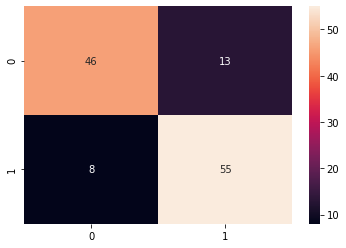

In [45]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegression(C = 2, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Running Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that logistic regression predicts the classes with an accuracy of 0.83.

The ranked list of features is then found using permutation importance and the model coefficients.

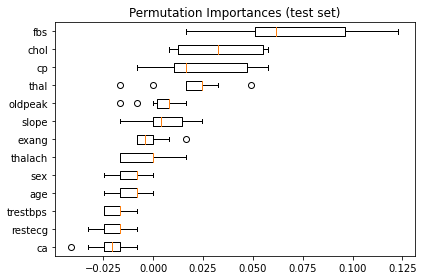

In [52]:
result = permutation_importance(model_lr, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Now, the features are added into the model, one feature at a time in order of their calculated importance.

In [53]:
bestAccuracy = [0, 0]

# intializing the first term
tempNames = []
tempNames.append(names[sorted_idx[12]])

start = time.time()

for i in range(12):

  # adding the other features based on their importance
  tempNames.append(names[sorted_idx[12-i]])

  # create new X term
  tempX = DATA[tempNames].to_numpy()

  # split the data into train and test sets
  trainX, testX, trainY, testY = train_test_split(tempX, Y, test_size = 0.4, random_state = 0)

  # build and tune the classifier
  model_lr = LogisticRegression(C = 2, max_iter = 10000)

  # fit the classifier to the training data
  model_lr.fit(trainX, trainY)  

  # predict the labels of the test set
  predictedY = model_lr.predict(testX)

  # find the mean cross-validation accuracy
  mean_cv_scores = np.mean(cross_val_score(model_lr, trainX, trainY, cv = 5))
    
  # save the hyperparameter reg_param if better than found before
  if mean_cv_scores > bestAccuracy[0]:
      bestAccuracy = [mean_cv_scores, i+1]

end = time.time()
print('Feature testing took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'features')

Feature testing took 2.8833484649658203 seconds

The best dev accuracy 0.8342342342342344 occured with 10 features


Now, the model will be run with the new set of features.

Running Logistic Regression Model took 7.933320999145508 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.79      0.69      0.74        59
           1       0.74      0.83      0.78        63

    accuracy                           0.76       122
   macro avg       0.77      0.76      0.76       122
weighted avg       0.76      0.76      0.76       122


Confusion Matrix:



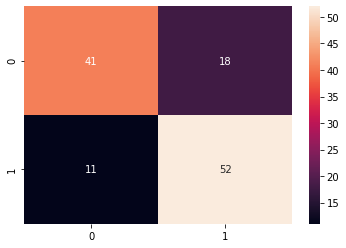

In [54]:
# create new list of feature names
newNames = []

# add features into new name list
for i in range(bestAccuracy[1]):
  newNames.append(names[sorted_idx[12-i]])

# create new X term
newX_o = DATA[newNames].to_numpy()

# create model
model_lr = LogisticRegression(C = 2, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Running Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that the accuracy saw no improvement with the feature selection. However, if we do dimensionality reduction on this new dataset, we can compare the accuracy of the new compressed data with the inital compressed data.

First, we run the the original PCA dataset to find if PCA can improve the accuracy.

Running Logistic Regression Model took 0.005211830139160156 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.51      0.59        59
           1       0.63      0.79      0.70        63

    accuracy                           0.66       122
   macro avg       0.67      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Confusion Matrix:



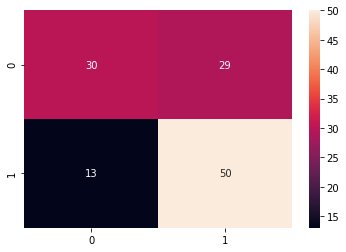

In [55]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegression(C = 2, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Running Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that the accuracy gets worse when PCA is used on the whole dataset. 

Now we will see if using PCA on the filtered dataset improves the accuracy.

The original dimension of the data is 10
The new dimension of the data is 2 and it explains 0.9796086519914605 of the variance
Running Logistic Regression Model took 0.009609222412109375 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.69      0.56      0.62        59
           1       0.65      0.76      0.70        63

    accuracy                           0.66       122
   macro avg       0.67      0.66      0.66       122
weighted avg       0.67      0.66      0.66       122


Confusion Matrix:



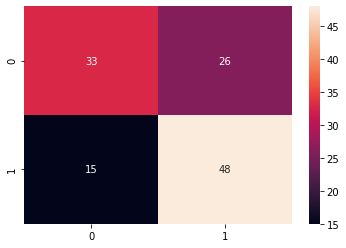

In [56]:
newX_pca = PCA(newX_o.astype('float64'), 0.95)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(newX_pca, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegression(C = 2, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Running Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

For the filtered dataset, using PCA does not improve the overall accuracy of the model.

We will now repeat this process for the tSNE dimentionality reduction method.

Tuning Logistic Regression Model took 0.023259878158569336 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.63      0.65        59
           1       0.67      0.71      0.69        63

    accuracy                           0.67       122
   macro avg       0.67      0.67      0.67       122
weighted avg       0.67      0.67      0.67       122


Confusion Matrix:



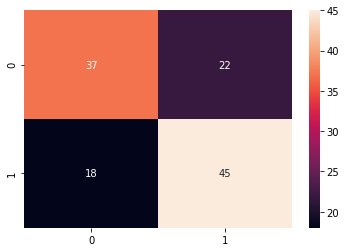

In [57]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegression(C = 2, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

On the original dataset, using tSNE causes a small increase in accuracy.

Now we will check using tSNE on the filtered dataset will improve the accuracy.

Running Logistic Regression Model took 0.005949735641479492 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.53      0.62        59
           1       0.65      0.84      0.74        63

    accuracy                           0.69       122
   macro avg       0.71      0.68      0.68       122
weighted avg       0.70      0.69      0.68       122


Confusion Matrix:



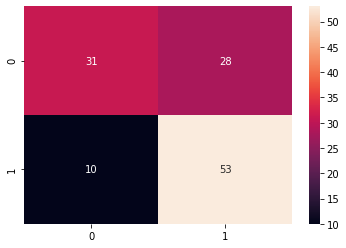

In [58]:
newX_tsne = TSNE(n_components = 3).fit_transform(newX_o)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(newX_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegression(C = 2, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Running Logistic Regression Model took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that running tSNE, this time on the filtered dataset, does improve the accuracy. 

Now, we will tune the hyperparameters of the models that are run on the models that performed the best in the inital results, where there is at least one model that used the non-compressed data, the PCA compressed data, and the tSNE compressed data.

First, we hyperparameter tune the model with the original dataset using cross-validation.

Tuning Logistic Regression Model took 1.5220146179199219 seconds
Grid search chose the C value of [2.11315789]

Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.78      0.81        59
           1       0.81      0.87      0.84        63

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122


Confusion Matrix:



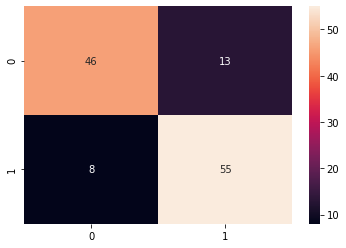

In [61]:
# hyperparameter values
cValues = np.linspace(0.01, 10.0, 20)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time() # time how long it takes to find the model

# create model
model_lr = LogisticRegressionCV(Cs = cValues, cv = 5, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# find best hyperparameter value
bestC_original = model_lr.C_
print('Grid search chose the C value of', bestC_original)

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that the accuracy with the hyperparameter tuned model is the same as the untuned model.

Now we will hyperparameter tune the PCA compressed version of the original dataset.

Tuning Logistic Regression Model took 0.13355207443237305 seconds
Grid search chose the C value of [0.01]

Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.51      0.59        59
           1       0.63      0.79      0.70        63

    accuracy                           0.66       122
   macro avg       0.67      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Confusion Matrix:



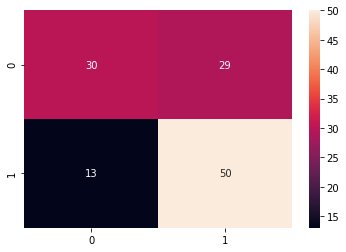

In [60]:
# hyperparameter values
cValues = np.linspace(0.01, 10, 20)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# create model
model_lr = LogisticRegressionCV(Cs = cValues, cv = 5, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# find best hyperparameter value
bestC_pca = model_lr.C_
print('Grid search chose the C value of', bestC_pca)

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Again, we can see that the tuned model has the same accuracy as the untuned model.

Now we will tune the tSNE compressed filtered dataset.

Tuning Logistic Regression Model took 0.12716150283813477 seconds
Grid search chose the C value of [0.01]

Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.53      0.62        59
           1       0.65      0.84      0.74        63

    accuracy                           0.69       122
   macro avg       0.71      0.68      0.68       122
weighted avg       0.70      0.69      0.68       122


Confusion Matrix:



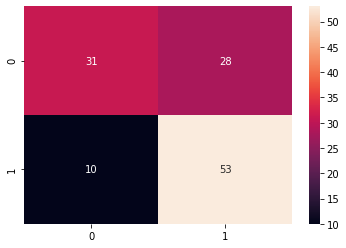

In [62]:
# hyperparameter values
cValues = np.linspace(0.01, 10, 20)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(newX_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# create model
model_lr = LogisticRegressionCV(Cs = cValues, cv = 5, max_iter = 10000)
model_lr.fit(trainX, trainY)

end = time.time()
print('Tuning Logistic Regression Model took', end - start, 'seconds')

# find best hyperparameter value
bestC_tsne = model_lr.C_
print('Grid search chose the C value of', bestC_pca)

# predict the labels of the test set
predictedY = model_lr.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that the tuned model performs the same as the untuned model.

Overall, the best logistical regression model for classifying heart disease is the model run on the original, unfiltered and uncompressed, dataset.

### Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) is a generalization of Fisher's linear discriminant that tries to create a linear boundary between points. 

We will first run the model initally, so that feature importance can be found afterwards.

Running LDA took 0.032144784927368164 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.69      0.77        59
           1       0.76      0.89      0.82        63

    accuracy                           0.80       122
   macro avg       0.81      0.79      0.79       122
weighted avg       0.80      0.80      0.79       122


Confusion Matrix:



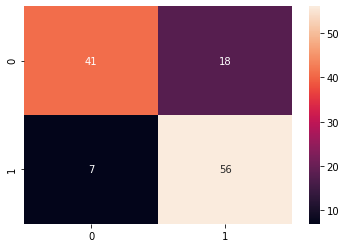

In [63]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that the accuracy of the (inital) LDA model is worse than the (inital) logistic regression model.

The ranked list of features is then found using permutation importance and the model coefficients.

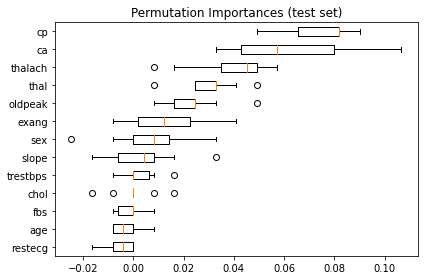

In [64]:
result = permutation_importance(model_lda, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Now, the features are added into the model, one feature at a time in order of their calculated importance.

In [65]:
bestAccuracy = [0, 0]

# intializing the first term
tempNames = []
tempNames.append(names[sorted_idx[12]])

start = time.time()

for i in range(12):

  # adding the other features based on their importance
  tempNames.append(names[sorted_idx[12-i]])

  # create new X term
  tempX = DATA[tempNames].to_numpy()

  # split the data into train and test sets
  trainX, testX, trainY, testY = train_test_split(tempX, Y, test_size = 0.4, random_state = 0)

  # build and tune the classifier
  model_lda = LinearDiscriminantAnalysis()

  # fit the classifier to the training data
  model_lda.fit(trainX, trainY)  

  # predict the labels of the test set
  predictedY = model_lda.predict(testX)

  # find the mean cross-validation accuracy
  mean_cv_scores = np.mean(cross_val_score(model_lda, trainX, trainY, cv = 5))
    
  # save the hyperparameter reg_param if better than found before
  if mean_cv_scores > bestAccuracy[0]:
      bestAccuracy = [mean_cv_scores, i+1]

end = time.time()
print('Feature testing took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'features')

Feature testing took 0.13603901863098145 seconds

The best dev accuracy 0.83993993993994 occured with 7 features


Now, the model will be run with the new set of features.

Running LDA took 0.0016214847564697266 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.83      0.73      0.77        59
           1       0.77      0.86      0.81        63

    accuracy                           0.80       122
   macro avg       0.80      0.79      0.79       122
weighted avg       0.80      0.80      0.79       122


Confusion Matrix:



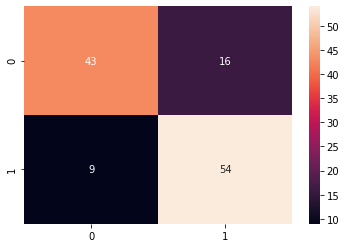

In [66]:
# create new list of feature names
newNames = []

# add features into new name list
for i in range(bestAccuracy[1]):
  newNames.append(names[sorted_idx[12-i]])

# create new X term
newX_o = DATA[newNames].to_numpy()

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(newX_o, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that the accuracy saw no improvement with the feature selection. However, if we do dimensionality reduction on this new dataset, we can compare the accuracy of the new compressed data with the inital compressed data.

First, we run the the original PCA dataset to find if PCA can improve the accuracy.

Running LDA took 0.0030395984649658203 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.51      0.59        59
           1       0.63      0.79      0.70        63

    accuracy                           0.66       122
   macro avg       0.67      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Confusion Matrix:



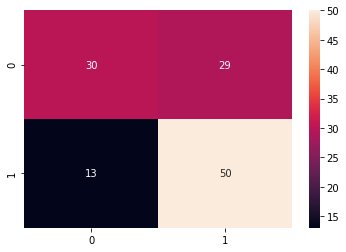

In [67]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that the accuracy gets worse when PCA is used on the whole dataset. 

Now we will see if using PCA on the filtered dataset improves the accuracy.

The original dimension of the data is 7
The new dimension of the data is 1 and it explains 0.9925604860434261 of the variance
Running LDA took 0.0040128231048583984 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.54      0.60        59
           1       0.64      0.76      0.70        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Confusion Matrix:



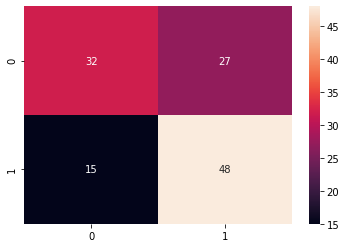

In [68]:
newX_pca = PCA(newX_o.astype('float64'), 0.95)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(newX_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Performing PCA on the filtered dataset gives the same results as performing PCA on the unfiltered dataset.

We will now repeat this for the tSNE compressed dataset.

Running LDA took 0.0022954940795898438 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.63      0.65        59
           1       0.67      0.71      0.69        63

    accuracy                           0.67       122
   macro avg       0.67      0.67      0.67       122
weighted avg       0.67      0.67      0.67       122


Confusion Matrix:



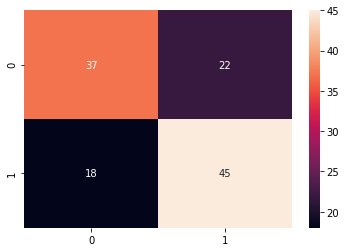

In [69]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Using tSNE gives a better accuracy than with using PCA.

Now we check if tSNE can improve the accuracy of the filtered dataset.

Running LDA took 0.0015380382537841797 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.58      0.44      0.50        59
           1       0.57      0.70      0.63        63

    accuracy                           0.57       122
   macro avg       0.57      0.57      0.56       122
weighted avg       0.57      0.57      0.57       122


Confusion Matrix:



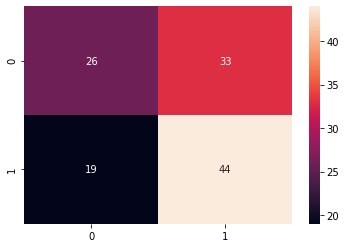

In [70]:
newX_tsne = TSNE(n_components = 3).fit_transform(newX_o)

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(newX_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_lda = LinearDiscriminantAnalysis()

# fit the LDA classifier to the training data
model_lda.fit(trainX, trainY)

end = time.time()
print('Running LDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_lda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that using tSNE on the filtered dataset does not improve the accuracy. Thus, the best performing LDA model is the model run on the uncompressed datasets, with the filtered dataset providing the same results as the unfiltered dataset.

LDA does not have any hyperparameters to tune, so no hyperparameter tuning will occur for this type of model.

### Quadrantic Discriminant Analysis (QDA)

Quadratic Discriminant Analysis (QDA) is a very similar method to LDA. The only difference between the two methods is that LDA assumes that the covariances between the classes are identical, and QDA does not. Thus, QDA tries to create a quadratic boundary between the classes.

For this dataset, there are only 2 classes being considered for the target variable. Thus, it is expected that QDA will perform similarly to LDA.

We will first run the model initally, so that feature importance can be found afterwards.

Running QDA took 0.002894163131713867 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.82      0.69      0.75        59
           1       0.75      0.86      0.80        63

    accuracy                           0.78       122
   macro avg       0.78      0.78      0.78       122
weighted avg       0.78      0.78      0.78       122


Confusion Matrix:



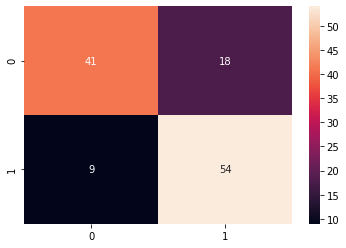

In [77]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = 0.5)

# fit the LDA classifier to the training data
model_qda.fit(trainX, trainY)

end = time.time()
print('Running QDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that for the original dataset, QDA is less accurate than LDA (by 0.01) in prediciting the classes. 

Now, we will perform feature selection, using permutation importance, to obtain the ranked list of featues.

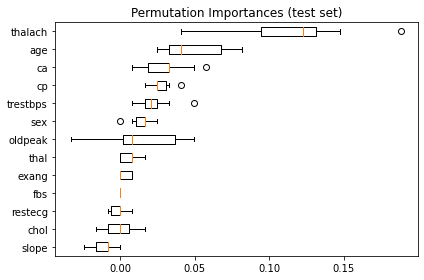

In [78]:
result = permutation_importance(model_qda, testX, testY, n_repeats = 10, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Now, we will see how many of the features will yield the best accuracy.

In [79]:
bestAccuracy = [0, 0]

# intializing the first term
tempNames = []
tempNames.append(names[sorted_idx[12]])

start = time.time()

for i in range(12):

  # adding the other features based on their importance
  tempNames.append(names[sorted_idx[12-i]])

  # create new X term
  tempX = DATA[tempNames].to_numpy()

  # split the data into train and test sets
  trainX, testX, trainY, testY = train_test_split(tempX, Y, test_size = 0.4, random_state = 0)

  # build and tune the classifier
  model_qda = QuadraticDiscriminantAnalysis(reg_param = 0.5)

  # fit the classifier to the training data
  model_qda.fit(trainX, trainY)  

  # predict the labels of the test set
  predictedY = model_qda.predict(testX)

  # find the mean cross-validation accuracy
  mean_cv_scores = np.mean(cross_val_score(model_qda, trainX, trainY, cv = 5))
    
  # save the hyperparameter reg_param if better than found before
  if mean_cv_scores > bestAccuracy[0]:
      bestAccuracy = [mean_cv_scores, i+1]

end = time.time()
print('Feature testing took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'features')

Feature testing took 0.1863245964050293 seconds

The best dev accuracy 0.8237237237237238 occured with 8 features


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

However, we can see that for QDA, adding the features into the model by order of importance yields an error for the colinearity of the features. This may because the covariance between the classes is not assumed, the correlation between the features is more important for QDA. Thus, we can't proceed any further with the feature selection.

We will then move onto testing the models run on the compressed datasets with the model run on the original dataset. First, we will run the PCA compressed dataset.

Running QDA took 0.006653308868408203 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.65      0.61      0.63        59
           1       0.66      0.70      0.68        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Confusion Matrix:



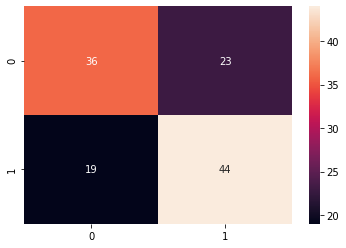

In [83]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = 0.5)

# fit the LDA classifier to the training data
model_qda.fit(trainX, trainY)

end = time.time()
print('Running QDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that using PCA does not improve the accuracy of the QDA model.

Next, we will try using the tSNE compressed dataset with QDA.

Running QDA took 0.0010013580322265625 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.58      0.62        59
           1       0.65      0.75      0.70        63

    accuracy                           0.66       122
   macro avg       0.67      0.66      0.66       122
weighted avg       0.67      0.66      0.66       122


Confusion Matrix:



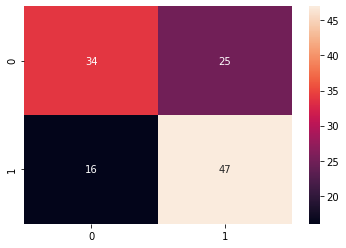

In [84]:
# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build the LDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = 0.5)

# fit the LDA classifier to the training data
model_qda.fit(trainX, trainY)

end = time.time()
print('Running QDA took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

For this model, using tSNE yields a better accuracy than using PCA, by 0.01.

Now, we will hyperparameter tune the 3 QDA models to see if accuracy is increased. The hyperparameter of the sklearn implimentation of QDA is 'reg_param,' where it regularizes the covariance estimates by transforming S2 (scaling attribute of a given class) as:
> S2 = (1 - reg_param) * S2 + reg_param * np.eye(n_features).

We will first tune the model run on the original dataset.

Tuning QDA took 0.24018168449401855 seconds

The best dev accuracy 0.8402402402402401 occured with 0.07 regularization parameter

Test Classification Report for 0.8237237237237238 reg_param:

               precision    recall  f1-score   support

           0       0.86      0.71      0.78        59
           1       0.77      0.89      0.82        63

    accuracy                           0.80       122
   macro avg       0.81      0.80      0.80       122
weighted avg       0.81      0.80      0.80       122


Confusion Matrix:



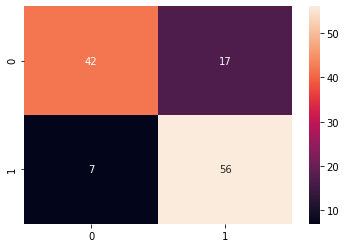

In [85]:
bestAccuracy_qda_o = [0, 0]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# test hyperparameters
for i in range(25):
    rp = i/100
    
    # build the QDA classifier
    model_qda = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model_qda.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model_qda, trainX, trainY, cv = 5))
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy_qda_o[0]:
        bestAccuracy_qda_o = [mean_cv_scores, rp]
        
end = time.time()
print('Tuning QDA took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy_qda_o[0], 'occured with', bestAccuracy_qda_o[1], 'regularization parameter')
        
# build the QDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy_qda_o[1])

# fit the QDA classifier to the training data
model_qda.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'reg_param:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see that the tuned QDA model performs better than the untuned QDA model, and the tuned LDA model.

Now we will do the same thing using the PCA compressed dataset.

Tuning QDA took 0.20082688331604004 seconds

The best dev accuracy 0.6962462462462462 occured with 0.24 regularization parameter

Test Classification Report for 0.6962462462462462 reg_param:

               precision    recall  f1-score   support

           0       0.65      0.58      0.61        59
           1       0.64      0.71      0.68        63

    accuracy                           0.65       122
   macro avg       0.65      0.65      0.64       122
weighted avg       0.65      0.65      0.65       122


Confusion Matrix:



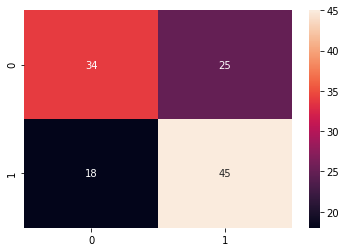

In [86]:
bestAccuracy_qda_pca = [0, 0]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# test hyperparameters
for i in range(25):
    rp = i/100
    
    # build the QDA classifier
    model_qda = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model_qda.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model_qda, trainX, trainY, cv = 5))
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy_qda_pca[0]:
        bestAccuracy_qda_pca = [mean_cv_scores, rp]
        
end = time.time()
print('Tuning QDA took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy_qda_pca[0], 'occured with', bestAccuracy_qda_pca[1], 'regularization parameter')
        
# build the QDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy_qda_pca[1])

# fit the QDA classifier to the training data
model_qda.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy_qda_pca[0], 'reg_param:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

The hyperparameter tuning does not improve the accuracy of the model using the PCA compressed dataset.

We will repreat this but using the tSNE compressed dataset.

Tuning QDA took 0.1790940761566162 seconds

The best dev accuracy 0.6686186186186186 occured with 0.0 regularization parameter

Test Classification Report for 0.6686186186186186 reg_param:

               precision    recall  f1-score   support

           0       0.68      0.58      0.62        59
           1       0.65      0.75      0.70        63

    accuracy                           0.66       122
   macro avg       0.67      0.66      0.66       122
weighted avg       0.67      0.66      0.66       122


Confusion Matrix:



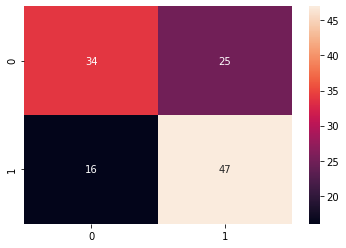

In [87]:
bestAccuracy_qda_tsne = [0, 0]

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# test hyperparameters
for i in range(25):
    rp = i/100
    
    # build the QDA classifier
    model_qda = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model_qda.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model_qda, trainX, trainY, cv = 5))
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy_qda_tsne[0]:
        bestAccuracy_qda_tsne = [mean_cv_scores, rp]
        
end = time.time()
print('Tuning QDA took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy_qda_tsne[0], 'occured with', bestAccuracy_qda_tsne[1], 'regularization parameter')
        
# build the QDA classifier
model_qda = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy_qda_tsne[1])

# fit the QDA classifier to the training data
model_qda.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_qda.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy_qda_tsne[0], 'reg_param:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

We can see (again) that the hyperparameter tuning does not improve the accuracy of the model using the tSNE compressed dataset.

Overall, the QDA model with the best accuracy is the tuned model run on the original dataset.

### Decision Tree Classifier

Decision Trees are non-parametric supervised learning models that predict the value of a target variable by learning simple decision rules that are inferred from the features. 

We will first run the model initally, so that feature importance can be found afterwards.

Tuning Decision Tree Classifier took 0.004729747772216797 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.63      0.66        59
           1       0.68      0.75      0.71        63

    accuracy                           0.69       122
   macro avg       0.69      0.69      0.69       122
weighted avg       0.69      0.69      0.69       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

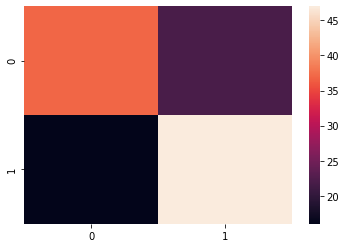

<Figure size 432x288 with 0 Axes>

In [190]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier(random_state = 0)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the accuracy of the decision tree classifier is at 0.75. This accuracy is not better than any of the models run beforehand.

Now, we will find the feature importance for this model. For this model and the following ones, we can directly extract the feature importance from the model.

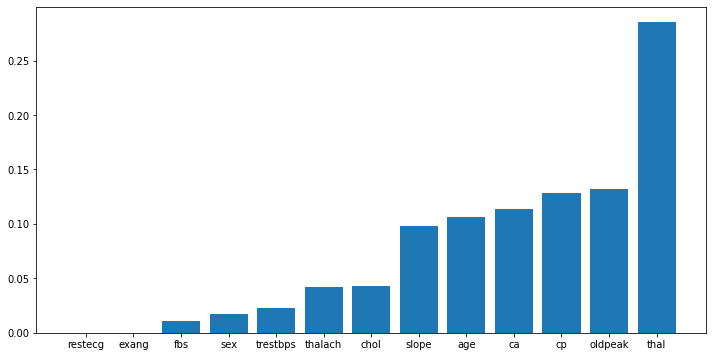

In [191]:
# get importance
featureImportance = model_dt.feature_importances_
sorted_idx = featureImportance.argsort()

# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(sorted_idx))], featureImportance[sorted_idx], tick_label = names[sorted_idx])
plt.show()

Now, from the above plot, we create the ranking for the features and check which features should be included by adding them into the model, one at a time base don their importance.

In [198]:
bestAccuracy = [0, 0]

# intializing the first term
tempNames = []
tempNames.append(names[sorted_idx[12]])

start = time.time()

for i in range(13):

  # adding the other features based on their importance
  tempNames.append(FI_list[0,12-i])

  # create new X term
  tempX = DATA[tempNames].to_numpy()

  # split the data into train and test sets
  trainX, testX, trainY, testY = train_test_split(tempX, Y, test_size = 0.4, random_state = 0)

  # build and tune the classifier
  model_dt = DecisionTreeClassifier(random_state = 0)

  # fit the classifier to the training data
  model_dt.fit(trainX, trainY)  

  # predict the labels of the test set
  predictedY = model_dt.predict(testX)

  # find the mean cross-validation accuracy
  mean_cv_scores = np.mean(cross_val_score(model_dt, trainX, trainY, cv = 5))
    
  # save the hyperparameter reg_param if better than found before
  if mean_cv_scores > bestAccuracy[0]:
      bestAccuracy = [mean_cv_scores, i+1]

end = time.time()
print('Feature testing took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'features')

Feature testing took 0.151108980178833 seconds

The best dev accuracy 0.773873873873874 occured with 5 features


Now, we will run the model with the features chosen above.

Tuning Decision Tree Classifier took 0.001089334487915039 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.68      0.70        59
           1       0.71      0.75      0.73        63

    accuracy                           0.71       122
   macro avg       0.71      0.71      0.71       122
weighted avg       0.71      0.71      0.71       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

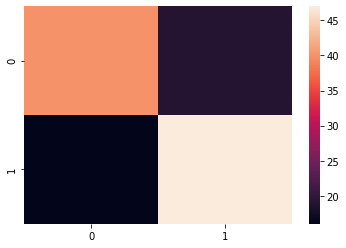

<Figure size 432x288 with 0 Axes>

In [199]:
# create new list of feature names
newNames = []

# add features into new name list
for i in range(bestAccuracy[1]):
  newNames.append(names[sorted_idx[12-i]])

# create new X term
newX_o = DATA[newNames].to_numpy()

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_o, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier(random_state = 0)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

The accuracy of the filtered dataset is more accurate than the original dataset. 

However, if we do dimensionality reduction on this new dataset, we can compare the accuracy of the new compressed data with the inital compressed data.

First, we run the the original PCA dataset to find if PCA can improve the accuracy.

Tuning Decision Tree Classifier took 0.0021398067474365234 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.58      0.59      0.59        59
           1       0.61      0.60      0.61        63

    accuracy                           0.60       122
   macro avg       0.60      0.60      0.60       122
weighted avg       0.60      0.60      0.60       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

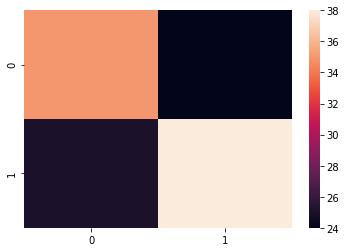

<Figure size 432x288 with 0 Axes>

In [200]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier(random_state = 0)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the accuracy of the model using the PCA compressed dataset is much less than the model using the original dataste.

Now we will perform PCA on the dataset with the best features, determined beforehand.

The original dimension of the data is 5
The new dimension of the data is 1 and it explains 0.957306248967992 of the variance
Tuning Decision Tree Classifier took 0.005752086639404297 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.64      0.61      0.63        59
           1       0.65      0.68      0.67        63

    accuracy                           0.65       122
   macro avg       0.65      0.65      0.65       122
weighted avg       0.65      0.65      0.65       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

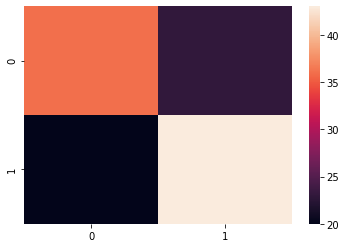

<Figure size 432x288 with 0 Axes>

In [202]:
newX_pca = PCA(newX_o.astype('float64'), 0.95)

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier(random_state = 0)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that using PCA on the filtered dataset yields a model that has a better accuracy than the model using the PCA compressed unfiltered data.

We will repeat this for the tSNE compressed data.

Tuning Decision Tree Classifier took 0.0018897056579589844 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.51      0.55        59
           1       0.60      0.68      0.64        63

    accuracy                           0.60       122
   macro avg       0.60      0.60      0.59       122
weighted avg       0.60      0.60      0.60       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

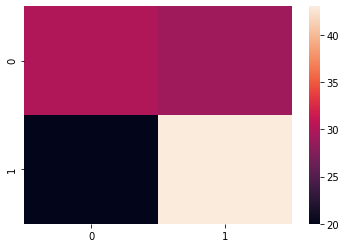

<Figure size 432x288 with 0 Axes>

In [203]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier(random_state = 0)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that using tSNE provides a model that has the same accuracy as the model that used PCA.

Now we will perform tSNE on the dataset with the best features, determined beforehand.

Tuning Decision Tree Classifier took 0.001402139663696289 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.52      0.39      0.45        59
           1       0.54      0.67      0.60        63

    accuracy                           0.53       122
   macro avg       0.53      0.53      0.52       122
weighted avg       0.53      0.53      0.52       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

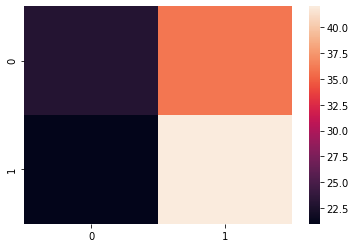

<Figure size 432x288 with 0 Axes>

In [204]:
newX_tsne = TSNE(n_components = 3).fit_transform(newX_o.astype('float64'))

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_dt = DecisionTreeClassifier(random_state = 0)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that using tSNE on the filtered dataset does not yield a model that is better than the model that uses tSNE on the unfiltered dataset.

Now, we will hyperparameter tune the models of each of the compression methods (and the original dataset). For each of the models, we will use grid search to find the optimal hyperparameters.

First, we will tune the model of the filtered, uncompressed dataset.

Tuning Decision Tree Classifier took 0.15596723556518555 seconds
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.83      0.82        59
           1       0.84      0.81      0.82        63

    accuracy                           0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

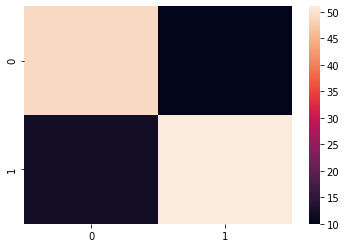

<Figure size 432x288 with 0 Axes>

In [206]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_o, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4]}
model_dt = GridSearchCV(DecisionTreeClassifier(random_state = 0), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# find best hyperparameters
print(model_dt.best_estimator_)

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that hyperparameter tuning the model with the filtered uncompressed dataset greatly improves the accuracy.

We will then tune the model using the PCA compressed filtered dataset (since it performed better than the PCA compressed unfiltered dataset).

Tuning Decision Tree Classifier took 0.15588998794555664 seconds
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.64      0.61      0.63        59
           1       0.65      0.68      0.67        63

    accuracy                           0.65       122
   macro avg       0.65      0.65      0.65       122
weighted avg       0.65      0.65      0.65       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

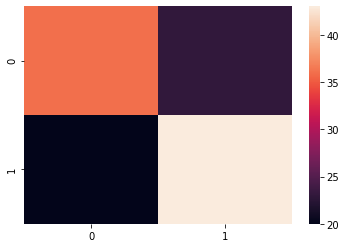

<Figure size 432x288 with 0 Axes>

In [211]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [0.4, 0.6, 0.8]}
model_dt = GridSearchCV(DecisionTreeClassifier(random_state = 0), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# find best hyperparameters
print(model_dt.best_estimator_)

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that tuning the model using the PCA compressed filtered dataset does not change the accuracy.

We will repeat the hyperparameter tuning for the model using the tSNE compressed filtered dataset.

Tuning Decision Tree Classifier took 0.16893315315246582 seconds
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.42      0.19      0.26        59
           1       0.50      0.76      0.60        63

    accuracy                           0.48       122
   macro avg       0.46      0.47      0.43       122
weighted avg       0.46      0.48      0.44       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

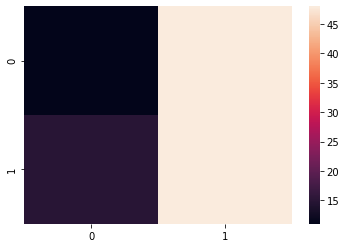

<Figure size 432x288 with 0 Axes>

In [212]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4]}
model_dt = GridSearchCV(DecisionTreeClassifier(random_state = 0), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_dt.fit(trainX, trainY)

end = time.time()
print('Tuning Decision Tree Classifier took', end - start, 'seconds')

# find best hyperparameters
print(model_dt.best_estimator_)

# predict the labels of the test set
predictedY = model_dt.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that tuning the model with the tSNE compressed filtered dataset greatly decreases the accuracy.

We can see that the most accurate decision tree classifier occurs when the uncompressed filtered dataset is used.

### Random Forest Classifier

Random Forests are ensemble learning methods that construct several decision trees at training time and outputting the class that is the mode of the classes (for classification) or mean prediction (for regression) of the individual trees. This type of method is a bagging method, which are methods that increases stability and accuracy while also reducing overfitting.

We will first run the model initally, so that feature importance can be found afterwards.

Tuning Random Forest took 0.14913392066955566 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.86      0.81      0.83        59
           1       0.83      0.87      0.85        63

    accuracy                           0.84       122
   macro avg       0.85      0.84      0.84       122
weighted avg       0.84      0.84      0.84       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

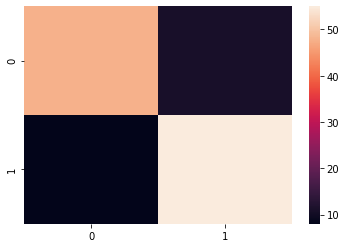

<Figure size 432x288 with 0 Axes>

In [175]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_rf = RandomForestClassifier(random_state = 0)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the untuned random forest model is more accurate than most of the other models that have been already run.

We will now find the feature importance of the model to see if filtering the data so that only the most important features are included increases the accuracy of the model.

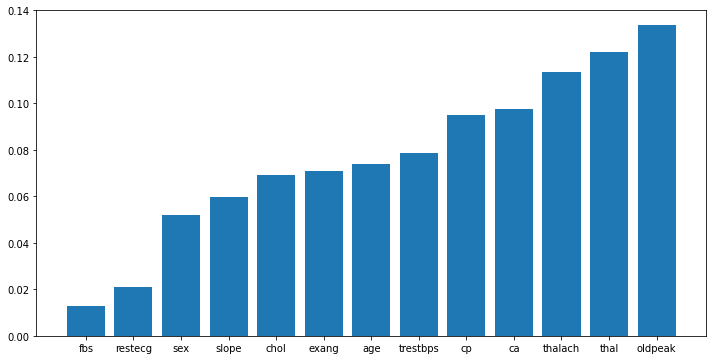

In [179]:
# get importance
featureImportance = model_rf.feature_importances_
sorted_idx = featureImportance.argsort()

# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(sorted_idx))], featureImportance[sorted_idx], tick_label = names[sorted_idx])
plt.show()

We can see that the feature importance graph has a similar order to the feature importance graph of the decision tree classifier.

Now, we will add the terms into the model one at a time.

In [181]:
bestAccuracy = [0, 0]

# intializing the first term
tempNames = []
tempNames.append(names[sorted_idx[12]])

start = time.time()

for i,j in enumerate(featureImportance):

  # adding the other features based on their importance
  tempNames.append(FI_list_2[0,12-i])

  # create new X term
  tempX = DATA[tempNames].to_numpy()

  # split the data into train and test sets
  trainX, testX, trainY, testY = train_test_split(tempX, Y, test_size = 0.4, random_state = 0)

  # build and tune the classifier
  model_rf = RandomForestClassifier(random_state = 0)

  # fit the classifier to the training data
  model_rf.fit(trainX, trainY)  

  # predict the labels of the test set
  predictedY = model_rf.predict(testX)

  # find the mean cross-validation accuracy
  mean_cv_scores = np.mean(cross_val_score(model_rf, trainX, trainY, cv = 5))
    
  # save the hyperparameter reg_param if better than found before
  if mean_cv_scores > bestAccuracy[0]:
      bestAccuracy = [mean_cv_scores, i+1]

end = time.time()
print('Feature testing took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'features')

Feature testing took 11.670794486999512 seconds

The best dev accuracy 0.850900900900901 occured with 12 features


We will run the model using the new set of features. However, since we can see that all 13 features are being used again, we should produce a similar accuracy to the inital model.

Tuning Random Forest took 0.14951658248901367 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.83      0.76      0.80        59
           1       0.79      0.86      0.82        63

    accuracy                           0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

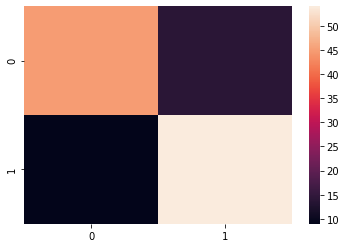

<Figure size 432x288 with 0 Axes>

In [182]:
# create new list of feature names
newNames = []

# add features into new name list
for i in range(bestAccuracy[1]):
  newNames.append(names[sorted_idx[12-i]])

# create new X term
newX_o = DATA[newNames].to_numpy()

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_o, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_rf = RandomForestClassifier(random_state = 0)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the accuracy of the above model is somewhat close to the intial model.

We now will check to see if dimensionality reduction on the unfiltered dataset will improve accuracy. We first run the model using the PCA compressed unfiltered dataset.

Tuning Random Forest took 0.1665027141571045 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.63      0.56      0.59        59
           1       0.63      0.70      0.66        63

    accuracy                           0.63       122
   macro avg       0.63      0.63      0.63       122
weighted avg       0.63      0.63      0.63       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

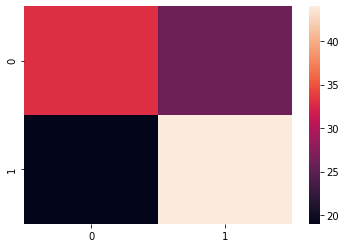

<Figure size 432x288 with 0 Axes>

In [183]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_rf = RandomForestClassifier(random_state = 0)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that PCA does not improve accuracy in comparison to the original dataset. 

We will now check the model using the PCA compressed filtered dataset.

The original dimension of the data is 12
The new dimension of the data is 3 and it explains 0.9825646583876877 of the variance
Tuning Random Forest took 0.20481586456298828 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.66      0.53      0.58        59
           1       0.63      0.75      0.68        63

    accuracy                           0.64       122
   macro avg       0.64      0.64      0.63       122
weighted avg       0.64      0.64      0.63       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

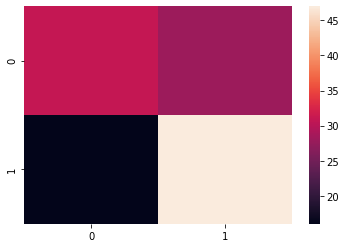

<Figure size 432x288 with 0 Axes>

In [184]:
newX_pca = PCA(newX_o.astype('float64'), 0.95)

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_rf = RandomForestClassifier(random_state = 0)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the filtered version of the dataset performs about the same as the unfiltered version.

We will repeat this process for the tSNE compressed datasets.

Tuning Random Forest took 0.14312124252319336 seconds

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.63      0.56      0.59        59
           1       0.63      0.70      0.66        63

    accuracy                           0.63       122
   macro avg       0.63      0.63      0.63       122
weighted avg       0.63      0.63      0.63       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

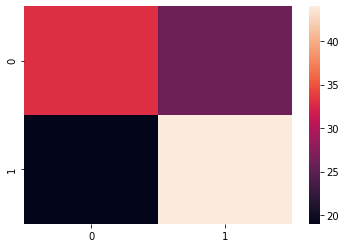

<Figure size 432x288 with 0 Axes>

In [185]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
model_rf = RandomForestClassifier(random_state = 0)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that using tSNE causes the model to predicit the same as when PCA is used.

However, we cannot compare this to a tSNE compressed filtered dataset. This is because tSNE produces a singleton array that cannot be used with the function 'train_test_split.'

Now, we will hyperparameter tune the models of each of the compression methods (and the original dataset). For each of the models, we will use grid search to find the optimal hyperparameters.

First, we will tune the model of the unfiltered, uncompressed dataset. 

Tuning Random Forest took 54.70141959190369 seconds
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.86      0.75      0.80        59
           1       0.79      0.89      0.84        63

    accuracy                           0.82       122
   macro avg       0.83      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

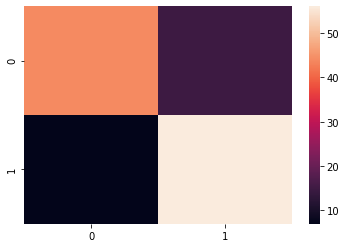

<Figure size 432x288 with 0 Axes>

In [214]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4], 'n_estimators': [100, 125, 150, 200]}
model_rf = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# find best hyperparameters
print(model_rf.best_estimator_)

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see the hyperparameter tuned model using the filtered uncompressed dataset performs similarly to the models using the other uncompressed datasets.

We will now tune the PCA compressed, filtered dataset. We used the filtered version of the dataset because while the overall accuracy is the same, there are small improvement otherwise.

Tuning Random Forest took 37.24359726905823 seconds
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.58      0.62        59
           1       0.65      0.73      0.69        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

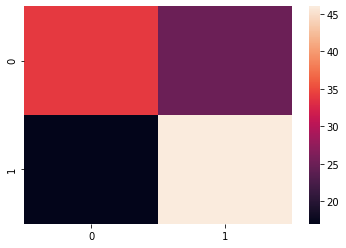

<Figure size 432x288 with 0 Axes>

In [187]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_pca, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4], 'n_estimators': [50, 100, 150, 200]}
model_rf = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# find best hyperparameters
print(model_rf.best_estimator_)

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the tuned PCA compressed model performs better than the untuned version of the model. 

We now tune the tSNE compressed model.

Tuning Random Forest took 37.267369747161865 seconds
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.59      0.59      0.59        59
           1       0.62      0.62      0.62        63

    accuracy                           0.61       122
   macro avg       0.61      0.61      0.61       122
weighted avg       0.61      0.61      0.61       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

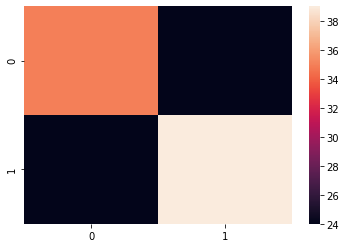

<Figure size 432x288 with 0 Axes>

In [188]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

start = time.time()

# build and tune the classifier
parameters = {'max_depth': [1, 5, 10, 100, None], 'max_features': [2, 3, 4], 'n_estimators': [50, 100, 150, 200]}
model_rf = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid = parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_rf.fit(trainX, trainY)

end = time.time()
print('Tuning Random Forest took', end - start, 'seconds')

# find best hyperparameters
print(model_rf.best_estimator_)

# predict the labels of the test set
predictedY = model_rf.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the tSNE compressed model performs worse than the untuned tSNE compressed model.

For the random forest model, the datasets that yield the best accuracy are the uncompressed datasets.

### XGBoost Classifier

XGBoost is a decision-tree-based ensemble method that uses a gradient boosting framework. XGBoost is one of the most popular boosting methods used today. Boosting is an ensemble method that creates a strong classifier from a number of weak classifiers by building a model from the training data, then creating a second model that attempts to correct the errors from the first model, and repeating that process until a strong classifier is made.

We will first run the model initally, so that feature importance can be found afterwards.


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.81      0.81        59
           1       0.82      0.81      0.82        63

    accuracy                           0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

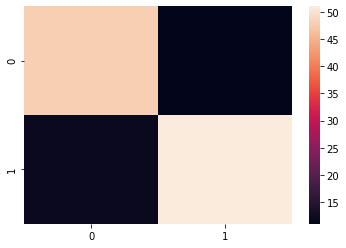

<Figure size 432x288 with 0 Axes>

In [168]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

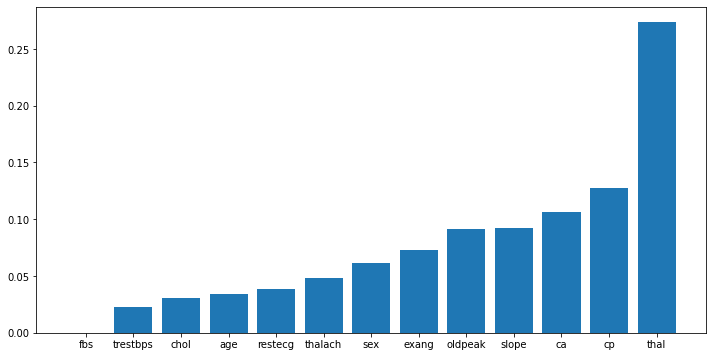

In [169]:
# get importance
featureImportance = model_xgb.feature_importances_
sorted_idx = featureImportance.argsort()

# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(sorted_idx))], featureImportance[sorted_idx], tick_label = names[sorted_idx])
plt.show()

We now check which combination of the features will produce the best accuracy.

In [170]:
bestAccuracy = [0, 0]

# intializing the first term
tempNames = []
tempNames.append(names[sorted_idx[12]])

start = time.time()

for i,j in enumerate(featureImportance):

  # adding the other features based on their importance
  tempNames.append(names[sorted_idx[12-i]])

  # create new X term
  tempX = DATA[tempNames].to_numpy()

  # split the data into train and test sets
  trainX, testX, trainY, testY = train_test_split(tempX, Y, test_size = 0.4, random_state = 0)

  # build and tune the classifier
  model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0)

  # fit the classifier to the training data
  model_xgb.fit(trainX, trainY)  

  # predict the labels of the test set
  predictedY = model_xgb.predict(testX)

  # find the mean cross-validation accuracy
  mean_cv_scores = np.mean(cross_val_score(model_xgb, trainX, trainY, cv = 5))
    
  # save the hyperparameter reg_param if better than found before
  if mean_cv_scores > bestAccuracy[0]:
      bestAccuracy = [mean_cv_scores, i+1]

end = time.time()
print('Feature testing took', end - start, 'seconds')

print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'features')

Feature testing took 1.5510895252227783 seconds

The best dev accuracy 0.8617117117117118 occured with 5 features


We now use those features in the model.


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.79      0.81      0.80        59
           1       0.82      0.79      0.81        63

    accuracy                           0.80       122
   macro avg       0.80      0.80      0.80       122
weighted avg       0.80      0.80      0.80       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

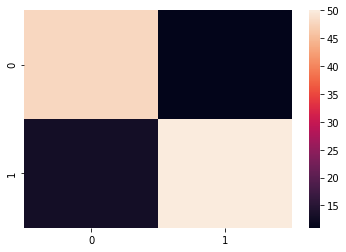

<Figure size 432x288 with 0 Axes>

In [171]:
# create new list of feature names
newNames = []

# add features into new name list
for i in range(bestAccuracy[1]):
  newNames.append(names[sorted_idx[12-i]])

# create new X term
newX_o = DATA[newNames].to_numpy()

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_o, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the accuracy of the model with the filtered dataset performs similarly to the model with the unfiltered dataset.


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.64      0.58      0.61        59
           1       0.64      0.70      0.67        63

    accuracy                           0.64       122
   macro avg       0.64      0.64      0.64       122
weighted avg       0.64      0.64      0.64       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

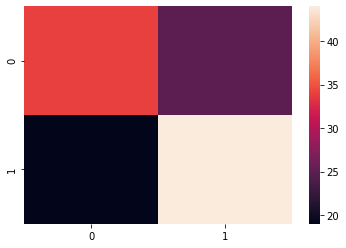

<Figure size 432x288 with 0 Axes>

In [172]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_pca, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the model with the PCA compressed unfiltered dataset performs worse than the uncompressed unfiltered dataset.

Now we check the accuracy of the model using the PCA compressed filtered dataset.

The original dimension of the data is 5
The new dimension of the data is 1 and it explains 0.957306248967992 of the variance

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.54      0.60        59
           1       0.64      0.76      0.70        63

    accuracy                           0.66       122
   macro avg       0.66      0.65      0.65       122
weighted avg       0.66      0.66      0.65       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

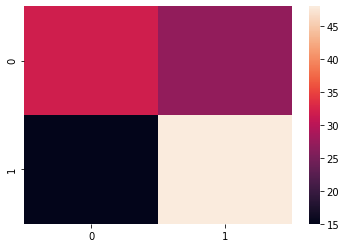

<Figure size 432x288 with 0 Axes>

In [215]:
newX_pca = PCA(newX_o.astype('float64'), 0.95)

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_pca, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

It can be seen that the model with the filtered PCA compressed dataset performs slightly better than the unfiltered verison.

We repeat this process for the tSNE compressed data.


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.61      0.61        59
           1       0.63      0.62      0.62        63

    accuracy                           0.61       122
   macro avg       0.61      0.61      0.61       122
weighted avg       0.61      0.61      0.61       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

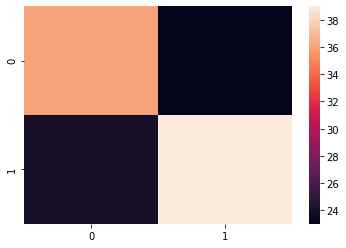

<Figure size 432x288 with 0 Axes>

In [173]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_tsne, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the model with the tSNE compressed unfiltered dataset performs worse than the model with the PCA compressed unfiltered dataset.

Now we check the accuracy of the model using the tSNE compressed filtered dataset.


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.66      0.56      0.61        59
           1       0.64      0.73      0.68        63

    accuracy                           0.65       122
   macro avg       0.65      0.64      0.64       122
weighted avg       0.65      0.65      0.64       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

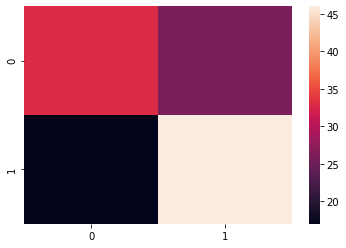

<Figure size 432x288 with 0 Axes>

In [216]:
newX_tsne = TSNE(n_components = 3).fit_transform(newX_o)

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_tsne, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
model_xgb = XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

It can be seen that the model with the filtered PCA compressed dataset performs slightly better than the unfiltered verison.

Now, we will hyperparameter tune the models of each of the compression methods (and the original dataset). For each of the models, we will use grid search to find the optimal hyperparameters.

First, we will tune the model of the unfiltered, uncompressed dataset. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.001, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.81      0.81        59
           1       0.83      0.83      0.83        63

    accuracy                           0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

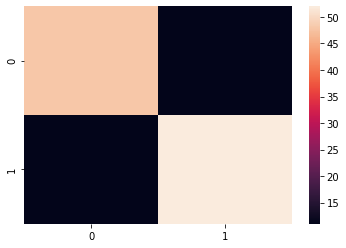

<Figure size 432x288 with 0 Axes>

In [ ]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
parameters = {'max_depth': [1, 5, 10, 100, None], 'learning_rate': [0.1, 0.5, 1, 2, 10], 
              'reg_alpha': [0.001, 0.01, 0.1, 1, 10], 'reg_lambda': [0.001, 0.01, 0.1, 1, 10]}
model_xgb = GridSearchCV(XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0), parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# find best hyperparameters
print(model_xgb.best_estimator_)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the tuned model performs similarly to the untuned version of the model.

We now tune the model with the PCA compressed filtered dataset.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=100,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.001, reg_lambda=0.001, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.59      0.63        59
           1       0.66      0.73      0.69        63

    accuracy                           0.66       122
   macro avg       0.67      0.66      0.66       122
weighted avg       0.66      0.66      0.66       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

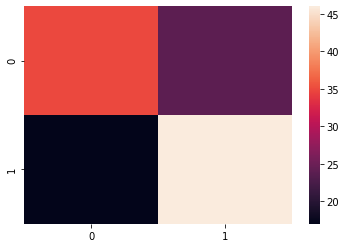

<Figure size 432x288 with 0 Axes>

In [217]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_pca, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
parameters = {'max_depth': [1, 5, 10, 100, None], 'learning_rate': [0.1, 0.5, 1, 2, 10], 
              'reg_alpha': [0.001, 0.01, 0.1, 1, 10], 'reg_lambda': [0.001, 0.01, 0.1, 1, 10]}
model_xgb = GridSearchCV(XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0), parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# find best hyperparameters
print(model_xgb.best_estimator_)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

We can see that the tuned version of the model performs better than the untuned version of the model.

Now we repeat this for the model using the tSNE compressed filtered dataset.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.57      0.53      0.55        59
           1       0.59      0.63      0.61        63

    accuracy                           0.58       122
   macro avg       0.58      0.58      0.58       122
weighted avg       0.58      0.58      0.58       122


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

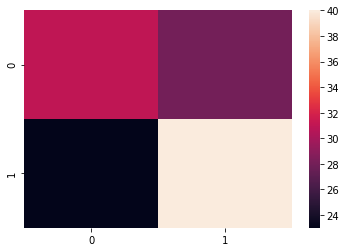

<Figure size 432x288 with 0 Axes>

In [218]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(newX_tsne, Y, test_size = 0.4, random_state = 0)

# set parameter values and grid search for optimal parameters
parameters = {'max_depth': [1, 5, 10, 100, None], 'learning_rate': [0.1, 0.5, 1, 2, 10], 
              'reg_alpha': [0.001, 0.01, 0.1, 1, 10], 'reg_lambda': [0.001, 0.01, 0.1, 1, 10]}
model_xgb = GridSearchCV(XGBClassifier(n_jobs = -1, eval_metric='mlogloss', random_state = 0), parameters, cv = 5, n_jobs = -1)

# fit the classifier to the training data
model_xgb.fit(trainX, trainY)

# find best hyperparameters
print(model_xgb.best_estimator_)

# predict the labels of the test set
predictedY = model_xgb.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

The tuned version of the model performs worse than the untuned version.

We can see that the best model is the model that uses the uncompressed unfiltered dataset.

## Conclusions

The best accuracies for each of the models are as follows.
1. LR: 0.83, uncompressed unfiltered
2. LDA: 0.79, uncompressed unfiltered
3. QDA: 0.80, uncompressed unfiltered 
4. DT: 0.82, uncompressed filtered (5 features: thal, oldpeak, cp, ca, age)
5. RF: 0.82, uncompressed unfiltered
6. XBG: 0.82, uncompressed unfiltered

Overall, we see that the model with the highest accuracy is the logistic regression model. However, we can see that the decision tree classifier, random forest classifier, and the XGBoost classifier are very close in accuracy to the logisitc regression model. Logisitc regression may be the best model because the data is not very large (303 data points) with only 13 features (excluding targets).

Alongside that, we see that for this data, the uncompressed data performs better than any of the datasets where the dimensionality reduction methods were done. This is likely because the dimensionality of the data was not too high. If the original 76 feature dataset was obtainable, then dimensionality reduction methods may be more helpful.

Between the dimensionality reduction methods, PCA performed better on average, while there were cases where tSNE was a bit more advantageous. The difference between the methods is that PCA is better at preserving linear structure, and tSNE is better at preserving local topology. For most models, preserving the linear structure yielded a better accuracy than preserving local topology.

We can see that for most of the models, the feature selection did not improve the accuracy of the model. The only model where it did improve accuracy was for the decision tree classifier. This is likely because the dimensionality of the data was not too high in the first place. If the original 76 feature dataset was obtainable, then the feature selection may be advantageous.

For logistic regression, LDA, and QDA, the features selected varied among all of the models. However, the decision tree, random forest, and XGBoost classifiers chose the same general set of features. These features were 'thal' (presence and type of defect), 'ca' (number of major vessels colored by flourosopy), 'cp' (chest pain type), 'oldpeak' (ST depression induced by exercise relative to rest). This difference may because permutation importance was used for logistic regression, LDA, and QDA, whereas the decision tree, random forest, and XGBoost classifiers had the CART algorithm for feature selection.